# Intraday Impact of Sundar Pichai's Tweets on Google Stock

## Introduction

This notebook analyses the immediate impact of Sundar Pichai's tweets on Google's stock prices using minute-by-minute data. The analysis includes:

1. **Data Loading**: Load tweets and Google's stock price data.
2. **Market Status**: Identify whether the market was open at the time of each tweet.
3. **Price & Return Calculation**: Compute the stock price at the time of the tweet and 10 minutes after, and calculate the stock return within 10 minutes after each tweet.
4. **Tweet Distribution**: Analyse the distribution of tweets by the hour of the day.
5. **Price Movement Analysis**: Extract price data for 10 minutes before and after each tweet, classify tweets based on price changes, and compare the average price movements.

Through this analysis, we aim to understand how Sundar Pichai's tweets impact Google's stock price in the short term.

## 1. Data Loading

In [1]:
# Imports necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# File paths
tweets_file_path = '/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Dataset/Tweets_Sundar_Pichai_Intraday_Analysis.csv'
stock_file_path = '/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Dataset/Google_minute_historical_data.csv'

In [3]:
# Load datasets
tweets_market_open = pd.read_csv(tweets_file_path)
price_goog = pd.read_csv(stock_file_path)

In [4]:
# Convert datetime columns to datetime objects
tweets_market_open['datetime'] = pd.to_datetime(tweets_market_open['datetime'], format='%d/%m/%Y %H:%M')
price_goog['Date'] = pd.to_datetime(price_goog['Date'], format='%d/%m/%Y %H:%M')

# Set the datetime as the index for price_tsla
price_goog.set_index('Date', inplace=True)

In [5]:
tweets_market_open.head()

,datetime,content,quote,replies,reposts,likes,views
0,2024-05-07 00:46:00,Today we’re launching Google Threat Intelligen...,0,85,306,1500,193000
1,2024-05-08 16:05:00,1.8M+ researchers have used GoogleDeepMind’s A...,0,83,339,2000,244000
2,2024-05-08 22:27:00,Glad to support the Secure By Design pledge an...,1,66,69,556,172000
3,2024-05-14 17:59:00,A beautiful day for #GoogleIO Almost showtime!,0,248,379,6500,362000
4,2024-05-17 22:34:00,Updated Gemini 1.5 Pro report: MATH benchmark ...,1,118,206,1400,460000


In [6]:
price_goog.head()

,Open,High,Low,Close,Tick Count,Volume
Date,,,,,,
2024-05-01 14:30:00,164.300,164.3900,163.68,163.9300,976,458376
2024-05-01 14:31:00,163.882,163.9700,163.39,163.3900,633,122600
2024-05-01 14:32:00,163.380,163.6381,163.17,163.1800,275,58666
2024-05-01 14:33:00,163.180,163.5039,163.09,163.4350,446,76526
2024-05-01 14:34:00,163.470,163.9600,163.43,163.8799,347,68055


## 2. Market Status

In [7]:
# Determine if the market was open at the time of the tweet
tweets_market_open['market_open'] = tweets_market_open['datetime'].isin(price_goog.index)

tweets_market_open.head()

,datetime,content,quote,replies,reposts,likes,views,market_open
0,2024-05-07 00:46:00,Today we’re launching Google Threat Intelligen...,0,85,306,1500,193000,False
1,2024-05-08 16:05:00,1.8M+ researchers have used GoogleDeepMind’s A...,0,83,339,2000,244000,True
2,2024-05-08 22:27:00,Glad to support the Secure By Design pledge an...,1,66,69,556,172000,False
3,2024-05-14 17:59:00,A beautiful day for #GoogleIO Almost showtime!,0,248,379,6500,362000,True
4,2024-05-17 22:34:00,Updated Gemini 1.5 Pro report: MATH benchmark ...,1,118,206,1400,460000,False


## 3. Price & Return Calculation

In [8]:
# Add the closing price at the time of the tweet
tweets_market_open['price'] = tweets_market_open.apply(
    lambda row: price_goog.loc[row['datetime'], 'Close'] if row['market_open'] else None, axis=1
)

In [9]:
# Add the closing price 10 minutes after the tweet
tweets_market_open['price_10min'] = tweets_market_open.apply(
    lambda row: price_goog.loc[row['datetime'] + pd.Timedelta(minutes=10), 'Close'] 
    if row['market_open'] and (row['datetime'] + pd.Timedelta(minutes=10)) in price_goog.index 
    else None, 
    axis=1
)

In [10]:
# Calculate the return
tweets_market_open['return'] = tweets_market_open.apply(
    lambda row: np.exp(np.log(row['price_10min'] / row['price'])) - 1 
    if pd.notnull(row['price']) and pd.notnull(row['price_10min']) and row['price'] != 0 else None, 
    axis=1
)

In [11]:
tweets_market_open[['price', 'price_10min', 'return', 'market_open']].head()

,price,price_10min,return,market_open
0,NaN,NaN,NaN,False
1,169.905,169.845,-0.000353,True
2,NaN,NaN,NaN,False
3,169.300,169.330,0.000177,True
4,NaN,NaN,NaN,False


## 4. Tweet Distribution

In [12]:
# Extract the hour from the datetime column
tweets_market_open['hour'] = tweets_market_open['datetime'].dt.hour

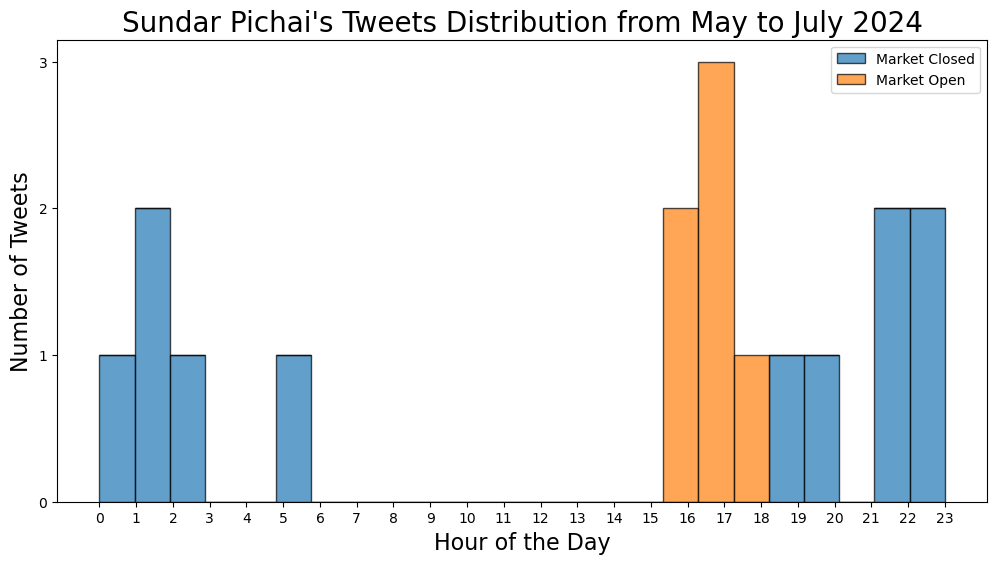

In [13]:
# Plot the distribution of tweets by hour
plt.figure(figsize=(12, 6))
plt.hist([tweets_market_open[tweets_market_open['market_open'] == False]['hour'], 
          tweets_market_open[tweets_market_open['market_open'] == True]['hour']],
         bins=24, stacked=True, edgecolor='black', label=['Market Closed', 'Market Open'], alpha=0.7)
plt.xticks(range(24))
plt.xlabel('Hour of the Day', fontsize=16)
plt.ylabel('Number of Tweets', fontsize=16)
plt.title('Sundar Pichai\'s Tweets Distribution from May to July 2024', fontsize=20)
plt.legend()
max_tweets = tweets_market_open['hour'].value_counts().max()
plt.yticks(range(0, max_tweets + 1))
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Google/figure_0.1.png', format='png', dpi=300)
plt.show()

## 5. Price Movement Analysis

In [14]:
# Filter for tweets during market open times
tweets_market_open = tweets_market_open[tweets_market_open['market_open']].copy()
tweets_market_open['id'] = range(1, len(tweets_market_open) + 1)

tweets_market_open.head()

,datetime,content,quote,replies,reposts,likes,views,market_open,price,price_10min,return,hour,id
1,2024-05-08 16:05:00,1.8M+ researchers have used GoogleDeepMind’s A...,0,83,339,2000,244000,True,169.905,169.8450,-0.000353,16,1
3,2024-05-14 17:59:00,A beautiful day for #GoogleIO Almost showtime!,0,248,379,6500,362000,True,169.300,169.3300,0.000177,17,2
5,2024-05-23 18:12:00,"Today we announced Umoja, the first fiber opti...",0,160,276,1600,131000,True,174.975,174.8684,-0.000609,18,3
7,2024-06-05 17:09:00,AI can play a role in solving infrastructure c...,0,89,102,604,95000,True,174.260,174.4734,0.001225,17,4
8,2024-06-06 16:36:00,"Amazed by how people are using NotebookLM, fro...",1,170,139,1000,195000,True,176.060,176.1400,0.000454,16,5


In [15]:
# Function to extract and fill the price window around each tweet
def get_price_window_filled(datetime):
    start_time = datetime - pd.Timedelta(minutes=10)
    end_time = datetime + pd.Timedelta(minutes=10)
    time_range = pd.date_range(start=start_time, end=end_time, freq='T')
    price_window = []
    for t in time_range:
        if t in price_goog.index:
            price_window.append(price_goog.loc[t, 'Close'])
        else:
            price_window.append(np.nan)
    # Replace front NaNs with the first available price
    first_valid = next((x for x in price_window if not np.isnan(x)), None)
    if first_valid is not None:
        price_window = [first_valid if np.isnan(x) else x for x in price_window]
    
    # Replace back NaNs with the last available price
    last_valid = next((x for x in reversed(price_window) if not np.isnan(x)), None)
    if last_valid is not None:
        price_window = [last_valid if np.isnan(x) else x for x in reversed(price_window)]
        price_window = list(reversed(price_window))
    
    return price_window

In [16]:
# Extract and combine the price windows
price_windows = [get_price_window_filled(datetime) for datetime in tweets_market_open['datetime']]

In [17]:
# Create column names for the price windows
columns = [f"T{i}" for i in range(-10, 11)]

# Create a new dataframe with the price windows
price_window_df = pd.DataFrame(price_windows, columns=columns)
price_window_df['id'] = tweets_market_open['id'].values
price_window_df.set_index('id', inplace=True)

price_window_df.head()

,T-10,T-9,T-8,T-7,T-6,T-5,T-4,T-3,T-2,T-1,...,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10
id,,,,,,,,,,,,,,,,,,,,,
1,169.8100,169.74,169.670,169.6500,169.7250,169.885,170.1085,169.96,169.9301,169.8801,...,169.910,169.96,169.8500,169.8050,169.78,169.735,169.82,169.8900,169.8200,169.8450
2,169.1700,169.20,169.170,169.1599,169.2100,169.220,169.1900,169.18,169.2000,169.3117,...,169.355,169.32,169.3787,169.3444,169.38,169.260,169.33,169.3200,169.3163,169.3300
3,174.9900,174.97,174.930,174.9700,174.9300,174.845,174.8450,174.89,174.9400,174.9300,...,175.000,174.97,175.0200,175.0150,175.00,174.965,174.84,174.8000,174.8800,174.8684
4,174.1000,174.00,174.045,174.1000,174.1797,174.390,174.3200,174.38,174.4150,174.4600,...,174.365,174.44,174.3800,174.3800,174.30,174.315,174.37,174.3602,174.3800,174.4734
5,176.0481,175.96,175.941,175.8800,175.8300,175.860,175.9500,175.96,176.0600,175.9900,...,176.130,176.07,176.0390,176.0400,176.04,176.080,176.10,176.1239,176.1549,176.1400


In [18]:
# Calculate mean price movements
mean_price = price_window_df.mean()

# Classify tweets into positive and negative based on T10 and T0
positive_tweets = price_window_df[price_window_df['T10'] > price_window_df['T0']]
negative_tweets = price_window_df[price_window_df['T10'] <= price_window_df['T0']]

# Calculate mean price movements for positive and negative tweets
mean_positive_price = positive_tweets.mean()
mean_negative_price = negative_tweets.mean()

# Normalize price movements to let T0 be 0 for comparison
mean_price_normalized = mean_price - mean_price['T0']
mean_positive_price_normalized = mean_positive_price - mean_positive_price['T0']
mean_negative_price_normalized = mean_negative_price - mean_negative_price['T0']

# Calculate the number of positive and negative tweets
num_positive_tweets = len(positive_tweets)
num_negative_tweets = len(negative_tweets)
num_all_tweets = len(price_window_df)

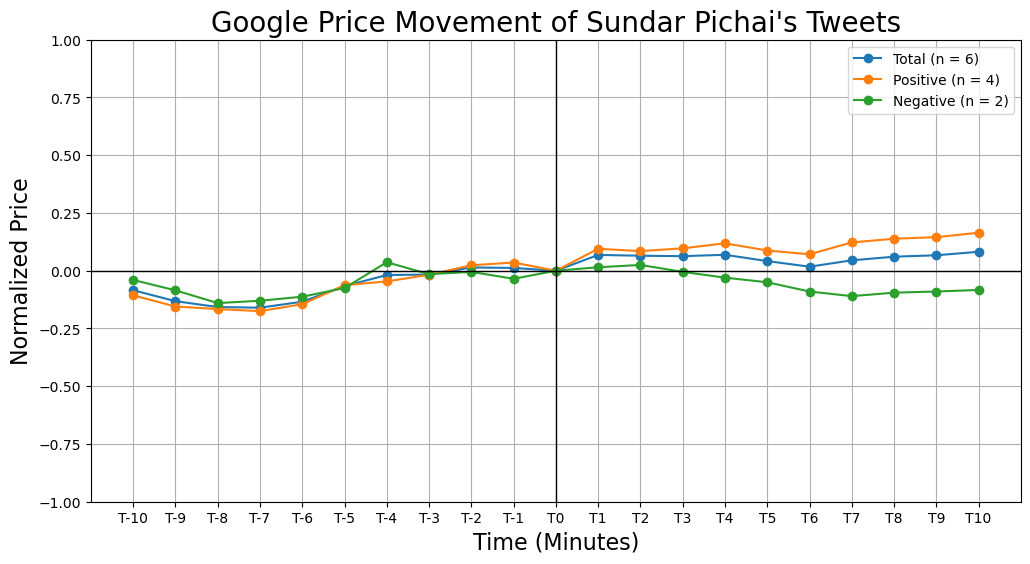

In [19]:
# Plot the normalized mean price movements with custom line colors and labels
plt.figure(figsize=(12, 6))
plt.plot(mean_price_normalized.index, mean_price_normalized.values, label=f'Total (n = {num_all_tweets})', marker='o', color='C0')
plt.plot(mean_positive_price_normalized.index, mean_positive_price_normalized.values, label=f'Positive (n = {num_positive_tweets})', marker='o', color='C1')
plt.plot(mean_negative_price_normalized.index, mean_negative_price_normalized.values, label=f'Negative (n = {num_negative_tweets})', marker='o', color='C2')

# Adding thicker grid lines at T0 and 0
plt.axhline(0, color='black', linestyle='-', linewidth=1)
plt.axvline('T0', color='black', linestyle='-', linewidth=1)

plt.ylim(-1.0, 1.0)
plt.xlabel('Time (Minutes)', fontsize=16)
plt.ylabel('Normalized Price', fontsize=16)
plt.title('Google Price Movement of Sundar Pichai\'s Tweets', fontsize=20)
plt.legend()
plt.grid(True)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Google/figure_0.2.png', format='png', dpi=300)
plt.show()

# Sentiment Analysis on Sundar Pichai's Tweets (Unsupervised)

## Introduction

This notebook performs a sentiment analysis on Sundar Pichai's tweets to evaluate their impact on public sentiment, particularly in relation to Google's stock performance. The analysis employs several methods to assess sentiment, including:

1. **Data Pre-processing**: Clean and prepare the tweet data for analysis by tokenizing, stemming, and removing noise.
2. **Dictionary Method of Apel and Grimaldi's**: Apply a dictionary-based approach to quantify sentiment using predefined positive and negative words.
3. **Rule-based Methods: VADER and TextBlob**: Utilize rule-based sentiment analysis tools, VADER and TextBlob, to gauge the sentiment of tweets.
4. **Sentiment Visualization**: Visualize the distribution of positive and negative sentiments across different methods.
5. **Performance Evaluation**: Evaluate the performance of each sentiment analysis method by comparing their predictions to actual stock price movements.

Through this comprehensive sentiment analysis, the goal is to explore how effectively different sentiment analysis techniques can predict the immediate market reaction to  Sundar Pichai's tweets, particularly those concerning Google. This study contributes to understanding the intersection between social media sentiment and stock market behavior.

## 1. Data Pre-processing

In [20]:
import pandas as pd
import re
import string
import contractions
import unicodedata
import spacy
import nltk
from nltk import SnowballStemmer

# Initialize necessary tools
nlp = spacy.load('en_core_web_sm')
stemmer = SnowballStemmer(language='english')
pattern = r"(?u)\b\w+\b"

def preprocess_text(texts):
    # Convert to lowercase, fix contractions, and strip whitespace
    texts = [contractions.fix(text.lower().strip()) for text in texts]
    # Tokenize texts
    tokens = [nltk.regexp_tokenize(text, pattern) for text in texts]
    # Normalize unicode characters and remove non-ascii characters
    tokens = [[unicodedata.normalize('NFKD', t).encode('ascii', 'ignore').decode('utf-8', 'ignore') for t in token_list] for token_list in tokens]
    # Remove single-character tokens except 'x'
    tokens = [[t for t in token_list if len(t) > 1] for token_list in tokens]
    # Remove punctuation
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [[regex.sub('', t) for t in token_list if t not in string.punctuation] for token_list in tokens]
    # Remove stopwords
    stopwords = set(nlp.Defaults.stop_words)
    tokens = [[t for t in token_list if t not in stopwords] for token_list in tokens]
    # Remove digits
    tokens = [[t for t in token_list if not t.isdigit()] for token_list in tokens]
    return tokens

# Apply preprocessing to the tweet content
tokens = preprocess_text(tweets_market_open['content'])
tweets_market_open['content_tokens'] = [' '.join(doc) for doc in tokens]

def stem_tokens(tokens):
    # Apply stemming to tokens
    return [[stemmer.stem(token) for token in token_list if '-' not in token] for token_list in tokens]

# Stem the tokens
stems = stem_tokens(tokens)
tweets_market_open['content_stems'] = [' '.join(doc) for doc in stems]

In [21]:
i = 5  # You can change this number to see different tweets

# Get the tweet content at the selected index
tweet_content = tweets_market_open['content'].iloc[i]
tweet_tokens = preprocess_text([tweet_content])[0]
tweet_stems = stem_tokens([tweet_tokens])[0]

# Print the results
print(f"Tweet Index: {i}\n")
print("Original Tweet Content:")
print(tweet_content)
print("\nTokens after Preprocessing:")
print(tweet_tokens)
print("\nStems after Preprocessing:")
print(tweet_stems)

Tweet Index: 5

Original Tweet Content:
Today at #SamsungUnpacked, we announced AI-powered updates to Gemini + Circle to Search, coming to the SamsungMobile Galaxy lineup. We’ll continue to partner with Samsung to build great mobile experiences on all Android devices, from tablets to wearables. 

Tokens after Preprocessing:
['today', 'samsungunpacked', 'announced', 'ai', 'powered', 'updates', 'gemini', 'circle', 'search', 'coming', 'samsungmobile', 'galaxy', 'lineup', 'continue', 'partner', 'samsung', 'build', 'great', 'mobile', 'experiences', 'android', 'devices', 'tablets', 'wearables']

Stems after Preprocessing:
['today', 'samsungunpack', 'announc', 'ai', 'power', 'updat', 'gemini', 'circl', 'search', 'come', 'samsungmobil', 'galaxi', 'lineup', 'continu', 'partner', 'samsung', 'build', 'great', 'mobil', 'experi', 'android', 'devic', 'tablet', 'wearabl']


## 2. Dictionary Method of Apel and Grimaldi's

In [22]:
# Define positive and negative words
pos_words = ["high", "higher", "highest", "strong", "stronger", "strongest", 
             "increase", "increases", "increased", "increasing", 
             "fast", "faster", "fastest"]
neg_words = ["low", "lower", "lowest", "weak", "weaker", "weakest", 
             "decrease", "decreases", "decreased", "decreasing", 
             "slow", "slower", "slowest"]

In [23]:
# Transform dictionary terms into stems
pos_stems = [stemmer.stem(t) for t in pos_words]
pos_stems = list(set(pos_stems))
neg_stems = [stemmer.stem(t) for t in neg_words]
neg_stems = list(set(neg_stems))

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Create a CountVectorizer with the positive and negative stems
count_vectorizer = CountVectorizer(vocabulary=pos_stems + neg_stems)
count_matrix = count_vectorizer.fit_transform(tweets_market_open['content_stems'])

# Calculate the positive and negative word counts
pos_counts = count_matrix[:, [count_vectorizer.vocabulary_.get(stem) for stem in pos_stems if stem in count_vectorizer.vocabulary_]].sum(axis=1)
neg_counts = count_matrix[:, [count_vectorizer.vocabulary_.get(stem) for stem in neg_stems if stem in count_vectorizer.vocabulary_]].sum(axis=1)

tweets_market_open['pos_word_count'] = pos_counts
tweets_market_open['neg_word_count'] = neg_counts

In [25]:
# Calculate the sentiment score using raw word counts
tweets_market_open['raw_count_sentiment'] = tweets_market_open.apply(
    lambda row: 0 if (row.pos_word_count == 0 and row.neg_word_count == 0) 
    else (row.pos_word_count - row.neg_word_count) / (row.pos_word_count + row.neg_word_count),
    axis=1
)

## 3. Rule-based Methods: VADER and TextBlob

In [26]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
tweets_market_open['vader_sentiment'] = tweets_market_open['content_stems'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Apply TextBlob sentiment analysis
tweets_market_open['textblob_sentiment'] = tweets_market_open['content_stems'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [27]:
# Define an index to select a tweet
i = 5  # You can change this number to see different tweets

# Get the tweet content at the selected index
tweet_content = tweets_market_open['content'].iloc[i]

# Get the sentiment scores
raw_count_sentiment = tweets_market_open['raw_count_sentiment'].iloc[i]
vader_sentiment = tweets_market_open['vader_sentiment'].iloc[i]
textblob_sentiment = tweets_market_open['textblob_sentiment'].iloc[i]

# Print the results
print(f"Tweet Index: {i}\n")
print("Original Tweet Content:")
print(tweet_content)
print("\nSentiment Scores:")
print(f"Raw Count Sentiment: {raw_count_sentiment}")
print(f"VADER Sentiment: {vader_sentiment}")
print(f"TextBlob Sentiment: {textblob_sentiment}")

Tweet Index: 5

Original Tweet Content:
Today at #SamsungUnpacked, we announced AI-powered updates to Gemini + Circle to Search, coming to the SamsungMobile Galaxy lineup. We’ll continue to partner with Samsung to build great mobile experiences on all Android devices, from tablets to wearables. 

Sentiment Scores:
Raw Count Sentiment: 0.0
VADER Sentiment: 0.6249
TextBlob Sentiment: 0.8


## 4. Sentiment Visualization

In [28]:
import matplotlib.pyplot as plt

# Function to label sentiment as positive or negative
def label(score):
     if score >= 0:
         return 1
     else:
         return 0

# Apply labeling for raw count, VADER, and TextBlob sentiments
tweets_market_open['raw_count_label'] = tweets_market_open['raw_count_sentiment'].apply(label)
tweets_market_open['vader_label'] = tweets_market_open['vader_sentiment'].apply(label)
tweets_market_open['textblob_label'] = tweets_market_open['textblob_sentiment'].apply(label)

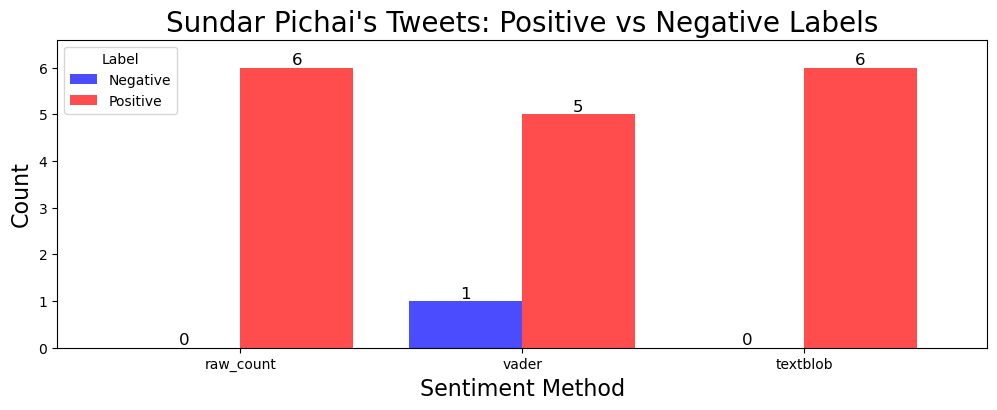

In [29]:

# Count the number of positive and negative labels for each sentiment method
label_counts = pd.DataFrame({
    'raw_count': tweets_market_open['raw_count_label'].value_counts(sort=False),
    'vader': tweets_market_open['vader_label'].value_counts(sort=False),
    'textblob': tweets_market_open['textblob_label'].value_counts(sort=False)
}).transpose()

# Rename columns for clarity
label_counts.columns = ['Negative', 'Positive']

# Plot the counts with custom colors and adjusted figure size
ax = label_counts.plot(kind='bar', figsize=(12, 4), color=['blue', 'red'], alpha=0.7, width=0.8)
plt.title('Sundar Pichai\'s Tweets: Positive vs Negative Labels', fontsize=20)
plt.xlabel('Sentiment Method', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=0)
plt.legend(title='Label', loc='upper left')

# Adjust the y-axis limits
ax.set_ylim(0, label_counts.max().max() * 1.1)

# Adding labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=12)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Google/figure_0.3.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Performance Evaluation

In [30]:
from sklearn.metrics import classification_report

# Merge the true labels from the price window dataset
price_window_df['label'] = price_window_df.apply(lambda row: 1 if row['T10'] >= row['T0'] else 0, axis=1)
tweets_market_open = tweets_market_open.merge(price_window_df[['label']], left_on='id', right_index=True, how='inner')

# Extract the true labels and predicted labels
true_labels = tweets_market_open['label']
raw_count_pred_labels = tweets_market_open['raw_count_label']
vader_pred_labels = tweets_market_open['vader_label']
textblob_pred_labels = tweets_market_open['textblob_label']

# Print detailed classification reports for each sentiment method
print("\nRaw Count Classification Report:")
print(classification_report(true_labels, raw_count_pred_labels))

print("\nVADER Classification Report:")
print(classification_report(true_labels, vader_pred_labels))

print("\nTextBlob Classification Report:")
print(classification_report(true_labels, textblob_pred_labels))


Raw Count Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6


VADER Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.80      1.00      0.89         4

    accuracy                           0.83         6
   macro avg       0.90      0.75      0.78         6
weighted avg       0.87      0.83      0.81         6


TextBlob Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/